In [1]:

import os
import shutil
import re
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
def savefigtight(figname):
  plt.savefig(figname)

In [3]:
def getAnalysisDF():
  df_raw = pd.read_excel(os.getenv("OAS2RAWTAB"))
  df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTIONS"))["MRI ID"].unique())]

  df_norm= pd.read_excel(os.getenv("OAS2NORM"))
  df_norm= df_norm[df_norm["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTIONS"))["MRI ID"].unique())]

  df_combo = pd.merge(left=df_raw, right=df_norm, on="MRI ID", suffixes=["_raw", "_norm"], how="outer")
  df_pred = pd.merge(df_combo, pd.read_excel(os.getenv("PREDICTIONS")).drop(columns=["Group"]), how="outer")
  return df_pred

def getSplitDF():
    df_split = pd.read_excel("OAS2-split.xlsx")
    df_raw = pd.read_excel(os.getenv("OAS2RAWTAB"))
    df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel("OAS2-split.xlsx")["MRI ID"].unique())]

    df_split = pd.merge(left=df_split, right=df_raw, on="MRI ID", suffixes=["_norm", "_raw"], how="outer")
    return df_split

df_pred = getAnalysisDF()
df_split = getSplitDF()


['train' 'validate' 'test']


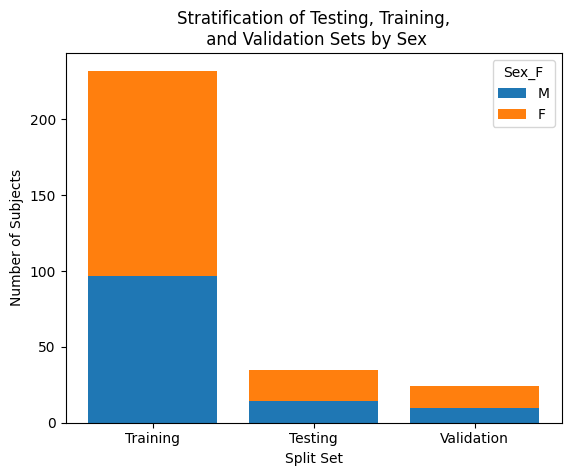

In [4]:
x = np.arange(len(df_split["Split"].unique()))
print(df_split["Split"].unique())

width = 0.3
m = 0


plt.bar(x+width, df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="M")
plt.bar(x+width, df_split[df_split["Sex_F"]==1]["Split"].value_counts(), bottom=df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="F")

plt.xticks(x+width, ["Training", "Testing", "Validation"])

plt.legend(title="Sex_F")
plt.title("Stratification of Testing, Training,\n and Validation Sets by Sex")
plt.xlabel("Split Set")
plt.ylabel("Number of Subjects")
savefigtight("sex-strat.png")

(array([15, 31, 48, 62, 47, 23]), array([60, 65, 70, 75, 80, 85, 90]))


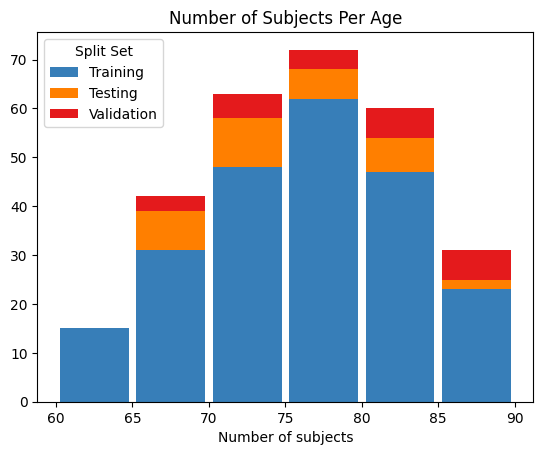

In [5]:
bins =  np.arange(60,95,5)
hist_tr = np.histogram(df_split[df_split["Split"]=="train"]["Age_raw"], bins)
hist_te = np.histogram(df_split[df_split["Split"]=="test"]["Age_raw"],     bins)
hist_va = np.histogram(df_split[df_split["Split"]=="validate"]["Age_raw"], bins)
print(hist_tr)
cmap = mpl.colormaps['Set1']
width = 0.9
plt.bar(np.arange(0,len(hist_tr[0]), 1), hist_tr[0], label="Training",width=width,  color=cmap(0.2))
plt.bar(np.arange(0,len(hist_te[0]), 1), hist_te[0], bottom=hist_tr[0], label="Testing", width=width, color=cmap(0.5))
plt.bar(np.arange(0,len(hist_va[0]), 1), hist_va[0], bottom=hist_tr[0] + hist_te[0], label="Validation", width=width, color=cmap(0.1))
plt.xticks(np.arange(0,len(hist_tr[0])+1, 1)-0.5, labels=bins)
plt.legend(title="Split Set")
plt.title("Number of Subjects Per Age")
plt.xlabel("Age (years)")
plt.xlabel("Number of subjects")
savefigtight("age-strat.png")
plt.show()


In [ ]:
import math

def getRec(df):
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  fn = float(len(df.query('TF == 0 and Prediction == 0')))
  if tp+fn == 0:
    return 1
  else:
    return tp/(fn+tp)

def getTPR(df):
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  fp = float(len(df.query('TF == 0 and Prediction == 1')))
  if tp+fp == 0:
    return 1
  else:
    return tp/(tp+fp)

def getFPR(df):
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  fp = float(len(df.query('TF == 0 and Prediction == 1')))
  if fp+tp == 0:
    return 1
  else:
    return fp/(tp+fp)

def getSpec(df):
  tn = len(df.query('TF == 1 and Prediction == 0'))
  fp = len(df.query('TF == 0 and Prediction == 1'))
  if (fp+tn) == 0:
    return 1
  else:
    return float(tn)/(fp+tn)

def getAcc(df):
  return float(len(df[df["TF"]==1]))/len(df)

def getMCC(df):
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  tn = float(len(df.query('TF == 1 and Prediction == 0')))
  fp = float(len(df.query('TF == 0 and Prediction == 1')))
  fn = float(len(df.query('TF == 0 and Prediction == 0')))

  numer = (tp*tn)-(fp*fn)
  denom = math.sqrt((tp + fp)*(tp + fn)*(tn+fp)*(tn+fn))
  if denom ==0:
    return 1
  else:
    return (numer)/(denom)


def getEOD(df_a,df_b):
  rec_a = getRec(df_a)
  rec_b = getRec(df_b)
  return rec_a-rec_b

def getAOD(df_a,df_b):

  tpr_a = getTPR(df_a)
  tpr_b = getTPR(df_b)
  fpr_a = getFPR(df_a)
  fpr_b = getFPR(df_b)

  return ((fpr_b-fpr_a)+(tpr_b-tpr_a))/2.

def getDI(df_a, df_b):
  a = float(len(df_a[df_a["Prediction"]==1]))/len(df_a)
  b = float(len(df_b[df_b["Prediction"]==1]))/len(df_b)
  return a/b

def getSPD(df_a, df_b):
  a = float(len(df_a[df_a["Prediction"]==1]))/len(df_a)
  b = float(len(df_b[df_b["Prediction"]==1]))/len(df_b)
  return a-b

def getAccDiff(df_a, df_b, asPercent=False):
  a = getAcc(df_a)
  b = getAcc(df_b)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getRecDiff(df_a, df_b, asPercent=False):
  a = getRec(df_a)
  b = getRec(df_b)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getSpecDiff(df_a, df_b, asPercent=False):
  a = getSpec(df_a)
  b = getSpec(df_b)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getMCCDiff(df_a, df_b, asPercent=False):
  a=getMCC(df_a)
  b=getMCC(df_b)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b


def getFairness(df_a, df_b):
  return pd.DataFrame({"EOD":[getEOD(df_a, df_b)], "AOD":[getAOD(df_a, df_b)], "DI": [getDI(df_a, df_b)], "SPD":[getSPD(df_a, df_b)]})


def printComparison(df_a, df_b, title_a="A", title_b="B"):
  print("-"*80)
  print(f"COMPARISON {title_a} vs. {title_b}")
  print("·"*40)
  print(f'Accuracy difference ({title_a} vs. {title_b}):   \t{getAccDiff(df_a, df_b , asPercent=True):+.2f}%')
  print(f'Recall difference ({title_a} vs. {title_b}):     \t{getRecDiff (df_a, df_b, asPercent=True):+.2f}%')
  print(f'Specificity difference ({title_a} vs. {title_b}):\t{getSpecDiff(df_a, df_b, asPercent=True):+.2f}%')
  print(f'MCC difference ({title_a} vs. {title_b}):        \t{getMCCDiff(df_a, df_b , asPercent=True):+.2f}%')
  print()
  print(f'Equal opportunity difference (EOD):\t{getEOD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getEOD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Average odds difference (AOD):     \t{getAOD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getAOD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Disparate impact (DI):             \t{getDI(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getDI(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print(f'Statistical parity index (SPD):    \t{getSPD(df_a, df_b):+.2f}\t{"In ideal range" if (-0.1<=getSPD(df_a, df_b)<=0.1) else "Not in ideal range"}')
  print("-"*80)


In [7]:
print(f'Accuracy:       {getAcc(df_pred):5.3f}')
print(f'Recall:         {getRec(df_pred):5.3f}')
print(f'Specificity:    {getSpec(df_pred):5.3f}')
print(f'MCC:            {getMCC(df_pred):+5.3f}')


Accuracy:       0.890
Recall:         0.850
Specificity:    0.917
MCC:            +0.770


In [8]:
print(df_pred["Age_raw"].median())

75.0


In [9]:
def getMetrics(df):
  acc =  [getAcc(df)]
  spec = [getSpec(df)]
  rec = [getRec(df)]
  mcc = [getMCC(df)]
  return pd.DataFrame({"Accuracy":acc, "Specificity":spec, "Recall":rec, "MCC":mcc})

def getSexMetrics(df):
  print(df["Sex_F"].unique())
  df_f = getMetrics(df[df["Sex_F"]==1])
  df_m = getMetrics(df[df["Sex_F"]==0])
  df_f["Sex_F"] = [1]
  df_m["Sex_F"] = [0]
  return pd.merge(df_f, df_m, how="outer")


def getAgeMetrics(df):


  df_age = pd.DataFrame(columns=["Accuracy","Specificity","Recall","MCC","Age_years"])
  # df_age["Age_range"] = f"<=75"

  # df_t = getMetrics(df.query("Age_raw > 75"))
  # df_t["Age_range"] = f" >75"

  # df_age = pd.merge(df_age, df_t, how="outer")

  # df_t = getMetrics(df.query("Age_raw >= 85"))
  # df_t["Age_range"] = f">=85"
  # df_age = pd.merge(df_age, df_t, how="outer")

  # for i in range(65, 95, 10):
  #   dq = df.query("Age_raw >= @i and Age_raw < @i+10")
  #   if len(dq)>0:
  #     df_t = getMetrics(dq)
  #     df_t["Age_range"] = f"{i:d} to {i+9:d}"
  #     df_age = pd.merge(df_age, df_t, how="outer")

  for a in df["Age_raw"].unique():
    df_t = getMetrics(df.query("Age_raw == @a"))
    df_t["Age_years"] = a
    df_age = pd.merge(df_age, df_t, how="outer")

  return df_age


In [10]:
df_sex = getSexMetrics(df_pred)
df_age = getAgeMetrics(df_pred)
# print(df_age.sort_values(by="Age_years"))

[0 1]


/tmp/ipykernel_537007/603022120.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_age = pd.merge(df_age, df_t, how="outer")
/tmp/ipykernel_537007/603022120.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_age = pd.merge(df_age, df_t, how="outer")
/tmp/ipykernel_537007/603022120.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_age = pd.merge(df_age, df_t, how="outer")
/tmp/ipykernel_537007/603022120.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_age = pd.merge(df_age, df_t, how="outer")
/tmp/ipykernel_537007/603022120.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_age = pd.mer

[0.         1.66666667 3.33333333 5.        ]
[0.88586957 0.83333333 0.93       0.77075548]
[0.89230769 0.95555556 0.75       0.74098154]


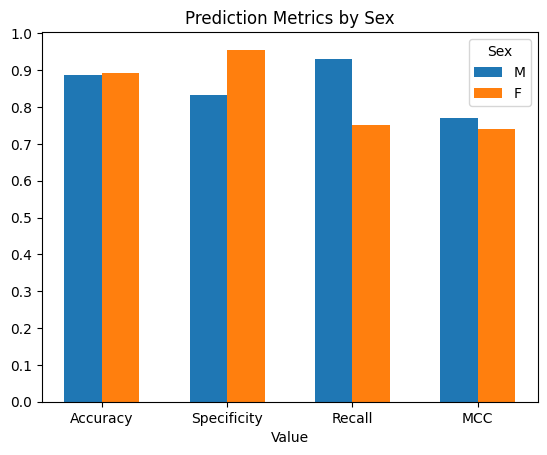

In [11]:

x_ticks = np.linspace(0,5,len(df_sex.keys())-1)
width = 0.5
i = 0
print(x_ticks)


for s in df_sex["Sex_F"].unique():
  row = df_sex[df_sex["Sex_F"]==s].values[0][:-1]
  print(row)
  oset = width*i
  plt.bar(x=x_ticks+oset, height=row, width=width, label=("F" if s==1 else "M"))
  i+=1
  plt.xticks(x_ticks+width/2, labels=df_sex[df_sex["Sex_F"]==s].keys()[:-1])
  plt.yticks(np.arange(0,1.1,0.1))
plt.legend(title="Sex")
plt.xlabel("Metric")
plt.xlabel("Value")
plt.title("Prediction Metrics by Sex")
plt.savefig("sex-metrics.png", bbox_inches="tight")
plt.show()


    EOD  AOD        DI       SPD
0 -0.18  0.0  0.449748 -0.319983


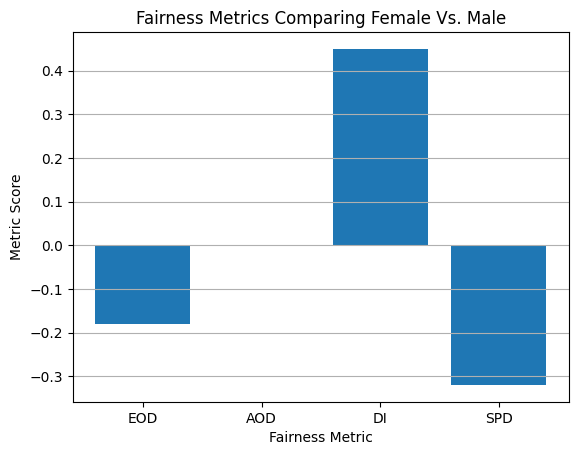

In [12]:
eq_sex = getFairness(df_pred[df_pred["Sex_F"]==1], df_pred[df_pred["Sex_F"]==0])
print(eq_sex)
plt.grid(visible=True, axis='y')
plt.bar(eq_sex.keys(), eq_sex.iloc[0])
plt.title("Fairness Metrics Comparing Female Vs. Male")
plt.xlabel("Fairness Metric")
plt.ylabel("Metric Score")
savefigtight("fairness-sex.png")
plt.show()

Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recal

/tmp/ipykernel_537007/1818262989.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")
/tmp/ipykernel_537007/1818262989.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")
/tmp/ipykernel_537007/1818262989.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")


Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'EDUC_raw'], dtype='object')


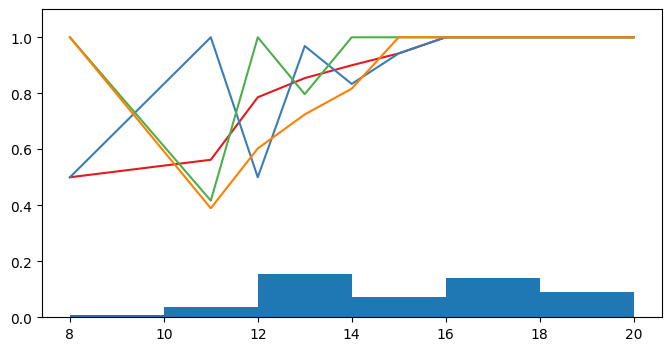

In [23]:
def makeEducationGraph(df):
  df_ed = df.sort_values(by="EDUC_raw")
  m = getMetrics(df_ed)
  cols = m.keys().to_list()
  cols+=["EDUC_raw"]
  df_edpred = pd.DataFrame(columns=cols)

  plt.figure(figsize=(8,4))

  metrs = []
  for ed in df_ed["EDUC_raw"].unique():
    m = getMetrics(df_ed[df_ed["EDUC_raw"]==ed])
    m["EDUC_raw"] = [ed]
    print(m.keys())
    print(df_edpred.keys())
    df_edpred = pd.merge(m, df_edpred, how="outer")

  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["Accuracy"], label="Accuracy",color=cmap(0.1))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["Specificity"], label="Specificity",color=cmap(0.2))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["Recall"], label="Recall",color=cmap(0.3))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["MCC"], label="MCC",color=cmap(0.5))
  plt.hist(df_ed["EDUC_raw"], 6, density=True)
  plt.ylim(0,1.1)



makeEducationGraph(df_pred)

In [25]:
def makeEducationGraph(df):
  df_ed = df.sort_values(by="EDUC_raw")
  m = getFairness(df_ed)
  cols = m.keys().to_list()
  cols+=["EDUC_raw"]
  df_edpred = pd.DataFrame(columns=cols)

  plt.figure(figsize=(8,4))

  metrs = []
  for ed in df_ed["EDUC_raw"].unique():
    m = getFairness(df_ed[df_ed["EDUC_raw"]==ed])
    m["EDUC_raw"] = [ed]
    print(m.keys())
    print(df_edpred.keys())
    df_edpred = pd.merge(m, df_edpred, how="outer")

  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["EOD"], label="EOD",color=cmap(0.1))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["AOD"], label="AOD",color=cmap(0.2))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["DI"], label="DI",color=cmap(0.3))
  plt.plot(df_ed["EDUC_raw"].unique(), df_edpred["SPD"], label="SPD",color=cmap(0.5))
  plt.hist(df_ed["EDUC_raw"], 6, density=True)
  plt.ylim(0,1.1)



makeEducationGraph(df_pred)

TypeError: getFairness() missing 1 required positional argument: 'df_b'

Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'MMSE_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recal

/tmp/ipykernel_537007/393249379.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")
/tmp/ipykernel_537007/393249379.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")


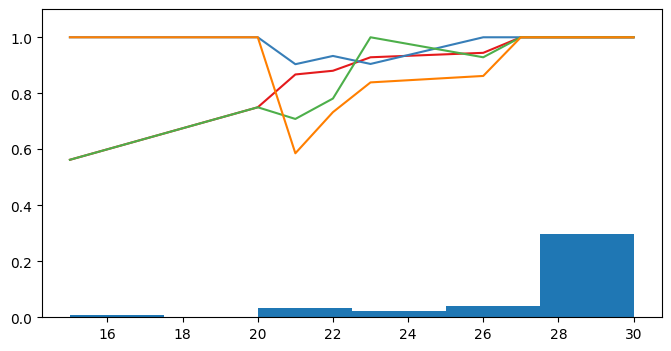

In [24]:
def makeEducationGraph(df):
  df_ed = df.sort_values(by="MMSE_raw")
  m = getMetrics(df_ed)
  cols = m.keys().to_list()
  cols+=["MMSE_raw"]
  df_edpred = pd.DataFrame(columns=cols)

  plt.figure(figsize=(8,4))

  metrs = []
  for ed in df_ed["MMSE_raw"].unique():
    m = getMetrics(df_ed[df_ed["MMSE_raw"]==ed])
    m["MMSE_raw"] = [ed]
    print(m.keys())
    print(df_edpred.keys())
    df_edpred = pd.merge(m, df_edpred, how="outer")

  plt.plot(df_ed["MMSE_raw"].unique(), df_edpred["Accuracy"], label="Accuracy",color=cmap(0.1))
  plt.plot(df_ed["MMSE_raw"].unique(), df_edpred["Specificity"], label="Specificity",color=cmap(0.2))
  plt.plot(df_ed["MMSE_raw"].unique(), df_edpred["Recall"], label="Recall",color=cmap(0.3))
  plt.plot(df_ed["MMSE_raw"].unique(), df_edpred["MCC"], label="MCC",color=cmap(0.5))
  plt.hist(df_ed["MMSE_raw"], 6, density=True)
  plt.ylim(0,1.1)



makeEducationGraph(df_pred)

Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')
Index(['Accuracy', 'Specificity', 'Recall', 'MCC', 'CDR_raw'], dtype='object')


/tmp/ipykernel_537007/2872308303.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")
/tmp/ipykernel_537007/2872308303.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")
/tmp/ipykernel_537007/2872308303.py:16: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_edpred = pd.merge(m, df_edpred, how="outer")


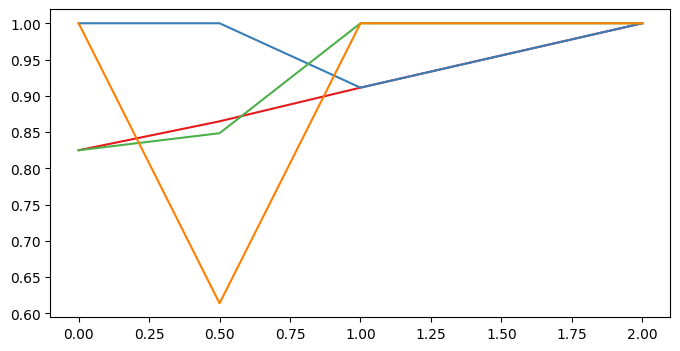

In [28]:
def makeEducationGraph(df):
  df_ed = df.sort_values(by="CDR_raw")
  m = getMetrics(df_ed)
  cols = m.keys().to_list()
  cols+=["CDR_raw"]
  df_edpred = pd.DataFrame(columns=cols)

  plt.figure(figsize=(8,4))

  metrs = []
  for ed in df_ed["CDR_raw"].unique():
    m = getMetrics(df_ed[df_ed["CDR_raw"]==ed])
    m["CDR_raw"] = [ed]
    print(m.keys())
    print(df_edpred.keys())
    df_edpred = pd.merge(m, df_edpred, how="outer")

  plt.plot(df_ed["CDR_raw"].unique(), df_edpred["Accuracy"], label="Accuracy",color=cmap(0.1))
  plt.plot(df_ed["CDR_raw"].unique(), df_edpred["Specificity"], label="Specificity",color=cmap(0.2))
  plt.plot(df_ed["CDR_raw"].unique(), df_edpred["Recall"], label="Recall",color=cmap(0.3))
  plt.plot(df_ed["CDR_raw"].unique(), df_edpred["MCC"], label="MCC",color=cmap(0.5))



makeEducationGraph(df_pred)

In [29]:
print(df_pred.keys())

Index(['Subject ID_raw', 'MRI ID', 'Group_raw', 'Visit_raw', 'MR Delay_raw',
       'M/F', 'Hand', 'Age_raw', 'EDUC_raw', 'SES', 'MMSE_raw', 'CDR_raw',
       'eTIV_raw', 'nWBV_raw', 'ASF_raw', 'Subject ID_norm', 'Group_norm',
       'Visit_norm', 'MR Delay_norm', 'Sex_F', 'Age_norm', 'EDUC_norm',
       'MMSE_norm', 'CDR_norm', 'eTIV_norm', 'nWBV_norm', 'ASF_norm',
       'Prediction', 'File', 'TF'],
      dtype='object')
